In [5]:
from qiskit.quantum_info import Operator, Pauli, PTM, pauli_basis
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import depolarizing_error, NoiseModel, pauli_error

import numpy as np
from random import choices, random
from numpy.random import permutation
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit

In [19]:
n=2
names = ["".join(str) for str in product(['I', 'X', 'Y','Z'], repeat=n)]
paulis = [Operator(Pauli(name)) for name in names]

def get_name(pauli_op):
    try:
        return names[min([i for (i,gate) in enumerate(paulis) if pauli_op.equiv(gate)])]
    except:
        return -1

def conjugate(pauli, cliffordop):
    return get_name(cliffordop.compose(Operator(Pauli(pauli).to_matrix())).compose(cliffordop))

In [20]:
p_group = pauli_basis(n, pauli_list = True).to_labels()
p_group_permuted = [conjugate(p, Operator(CZGate())) for p in p_group]
pairs = list(zip(p_group, p_group_permuted))
print(pairs)

[('II', 'II'), ('IX', 'ZX'), ('IY', 'ZY'), ('IZ', 'IZ'), ('XI', 'XZ'), ('XX', 'YY'), ('XY', 'YX'), ('XZ', 'XI'), ('YI', 'YZ'), ('YX', 'XY'), ('YY', 'XX'), ('YZ', 'YI'), ('ZI', 'ZI'), ('ZX', 'IX'), ('ZY', 'IY'), ('ZZ', 'ZZ')]


II : (1+0j)
IX : (1+0j)
IY : (0.96+0j)
IZ : (0.96+0j)
XI : (0.96+0j)
XX : (0.96+0j)
XY : (0.96+0j)
XZ : (0.96+0j)
YI : (1+0j)
YX : (1+0j)
YY : (0.96+0j)
YZ : (0.96+0j)
ZI : (0.96+0j)
ZX : (0.96+0j)
ZY : (0.96+0j)
ZZ : (0.96+0j)


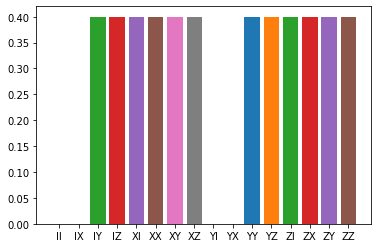

In [141]:
errorgen = 4
errorops = choices(p_group, k=errorgen)
errorprobs = [random()*.1/errorgen for op in errorops]
twoqubit_error = pauli_error([(Pauli(op), .01) for op in ["YI", "IX", "YX"]]+[(Pauli("II"), .97)])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli.to_label()] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real)
    print(pauli, ":", transfer_matrix[i][i])

SHOTS = 10000

In [84]:
def get_expectation(circuit, pauli_str):
    circ = circuit.copy()
    circ.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    counts = execute(circ, backend, shots = SHOTS, noise_model = noise_model, basis_gates = noise_model.basis_gates, optimization_level=0).result().get_counts()
    total = 0
    for key in counts.keys():
        pauli_weight = [{"I":'0'}.get(p,'1') for p in pauli_str]
        total += (-1)**sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pauli_weight, key)])*counts[key]
    return total/SHOTS

def measure_circuit(pauli_prep, pauli_meas, depth):
    total = 0
    qc = QuantumCircuit(2)
    for i,p in enumerate(pauli_prep[::-1]):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.h(i)
                qc.s(i)
    for i in range(depth):
        qc.cz(0,1)
    for i,p in enumerate(pauli_meas[::-1]):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.sdg(i)
                qc.h(i)
    return qc 

In [85]:
single_pairs = set()
for p1, p2 in zip(p_group, p_group_permuted):
    if 'I' in p1 and not 'I' in p2:
        single_pairs.add((p2,p1))
    if 'I' in p2 and not 'I' in p1:
        single_pairs.add((p1,p2))
print(single_pairs)

{('XZ', 'XI'), ('ZY', 'IY'), ('YZ', 'YI'), ('ZX', 'IX')}


In [86]:
for double, single in single_pairs:
    circ = measure_circuit(double,double,1)
    print(single, get_expectation(circ, single), real_errors[single]) #no spam, otherwise divide by single measurement

XI 1.0 (1+0j)
IY 0.963 (0.96+0j)
YI 0.9588 (0.96+0j)
IX 1.0 (1+0j)


In [87]:
depths = [1,3,5,7,9,11,13]
for double, single in single_pairs:
    res = []
    for d in depths:
        circ = measure_circuit(double, double, d)
        res.append(get_expectation(circ, single))
    expfit = lambda x,a,b: np.exp(-b*x)*a
    popt, pcov = curve_fit(expfit, depths, res)
    fid = expfit(1,1,popt[1])
    print(single, "real:", real_errors[single], "measured:", fid, "pair:", np.sqrt(real_errors[single]*real_errors[double]))

XI real: (1+0j) measured: 0.9797236367017296 pair: (0.9797958971132712+0j)
IY real: (0.96+0j) measured: 0.9600998973316762 pair: (0.96+0j)
YI real: (0.96+0j) measured: 0.9605890372954362 pair: (0.96+0j)
IX real: (1+0j) measured: 0.979256076202965 pair: (0.9797958971132712+0j)


In [88]:
depths = [2,4,6,8,10,12,14]
for double, single in single_pairs:
    res = []
    for d in depths:
        circ = measure_circuit(double, double, d)
        res.append(get_expectation(circ, double))
    expfit = lambda x,a,b: np.exp(-b*x)*a
    popt, pcov = curve_fit(expfit, depths, res)
    fid = expfit(1,1,popt[1])
    print(double, "real:", real_errors[double], "measured:", fid, "pair:", np.sqrt(real_errors[single]*real_errors[double]))

XZ real: (0.96+0j) measured: 0.9797277055009549 pair: (0.9797958971132712+0j)
ZY real: (0.96+0j) measured: 0.959378187787746 pair: (0.96+0j)
YZ real: (0.96+0j) measured: 0.9593365772694431 pair: (0.96+0j)
ZX real: (0.96+0j) measured: 0.9799604740877566 pair: (0.9797958971132712+0j)


In [89]:
for p1, p2 in pairs:
    circ = measure_circuit(p1, p2, 1)
    res = get_expectation(circ, p2)
    print(p2, "measured:", np.abs(res), "ideal", real_errors[p2])

II measured: 1.0 ideal (1+0j)
ZX measured: 0.9608 ideal (0.96+0j)
ZY measured: 0.9598 ideal (0.96+0j)
IZ measured: 0.9612 ideal (0.96+0j)
XZ measured: 0.962 ideal (0.96+0j)
YY measured: 0.9636 ideal (0.96+0j)
YX measured: 0.959 ideal (0.96+0j)
XI measured: 1.0 ideal (1+0j)
YZ measured: 0.9618 ideal (0.96+0j)
XY measured: 0.9584 ideal (0.96+0j)
XX measured: 1.0 ideal (1+0j)
YI measured: 0.9622 ideal (0.96+0j)
ZI measured: 0.9602 ideal (0.96+0j)
IX measured: 1.0 ideal (1+0j)
IY measured: 0.96 ideal (0.96+0j)
ZZ measured: 0.9642 ideal (0.96+0j)


In [90]:
double_pairs = []
for p1, p2 in pairs:
    if not ("I" in p1 or "I" in p2 or (p2,p1) in double_pairs or p1 == p2):
        double_pairs.append((p1,p2))

print(double_pairs)

[('XX', 'YY'), ('XY', 'YX')]


In [127]:
def measure_double(pauli, pauli_pair, depth):
    qc = QuantumCircuit(n)

    for i,p in enumerate(pauli[::-1]):
        match p:
            case "X":
                qc.h(i)
            case "Y":
                qc.h(i)
                qc.s(i)

    qc.barrier()
    
    for i in range(depth):
        for i,p in enumerate(zip(pauli[::-1], pauli_pair[::-1])):
            match p:
                case ("X","Y"):
                    qc.s(i)
                case ("X", "Z"):
                    qc.h(i)
                case ("Y", "X"):
                    qc.sdg(i)
                case ("Y", "Z"):
                    qc.sdg(i)
                    qc.h(i)
                case ("Z", "X"):
                    qc.h(i)
                case ("Z", "Y"):
                    qc.h(i)
                    qc.s(i)


        qc.cz(0,1) 
        qc.barrier()
    for i,p in enumerate(pauli[::-1]):
        match p:
            case "X":
                qc.h(i)
            case "Y":
                qc.sdg(i)
                qc.h(i)

    return qc

In [143]:
results = []
depths = [2,4,6,8,10,12] #has to be even
for d in depths:
    circ = measure_double("XY", "YX", d)
    results.append(get_expectation(circ, "XY"))
popt, pcov = curve_fit(expfit, depths, results)
print("real:", real_errors['XY'], "measured", np.exp(-popt[1]))

real: (0.96+0j) measured 0.9606297758788682


In [845]:
easy_group = [p for p,b in pairs if p==b]
print(easy_group)

['II', 'IZ', 'ZI', 'ZZ']


In [129]:
circ = measure_double("XY", "YX", 2)
circ.measure_all()
circ.draw()

┌───┐┌───┐ ░ ┌─────┐    ░ ┌─────┐    ░ ┌─────┐┌───┐ ░ ┌─┐   
   q_0: ┤ H ├┤ S ├─░─┤ Sdg ├─■──░─┤ Sdg ├─■──░─┤ Sdg ├┤ H ├─░─┤M├───
        ├───┤└───┘ ░ └┬───┬┘ │  ░ └┬───┬┘ │  ░ └┬───┬┘└───┘ ░ └╥┘┌─┐
   q_1: ┤ H ├──────░──┤ S ├──■──░──┤ S ├──■──░──┤ H ├───────░──╫─┤M├
        └───┘      ░  └───┘     ░  └───┘     ░  └───┘       ░  ║ └╥┘
meas: 2/═══════════════════════════════════════════════════════╩══╩═
                                                               0  1